<a href="https://colab.research.google.com/github/petarSuki/Exercise/blob/main/Audio_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])



In [ ]:
glob ('../input/sample_data/primer1.wav')

In [ ]:
! pip install tensorflow-io==0.32.0
! pip install tensorflow==2.12
# ! pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 73.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.33.0
    Uninstalling tensorflow-io-gcs-filesystem-0.33.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.33.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tensorflow-estimator
 

In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import scipy as sp

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten

In [ ]:
CAPUCHIN_FILE = "/content/drive/MyDrive/Bird_project_dataset/Parsed_Capuchinbird_Clips/XC114131-0.wav"
NOT_CAPUCHIN_FILE = "/content/drive/MyDrive/Bird_project_dataset/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav"

In [ ]:
def load_wav_16k_mono(filename):
    #Ucitava enkodirani wav file
    file_contents = tf.io.read_file(filename)
    #Dekodira wav (tensore po kanalu)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    #Brise bilo kakvu dodatnu dimenziju i ostavlja samo jedan kanal
    wav = tf.squeeze(wav, axis = 1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    #Ide sa 44100HZ na 16000HZ - ampliltude audio signala
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

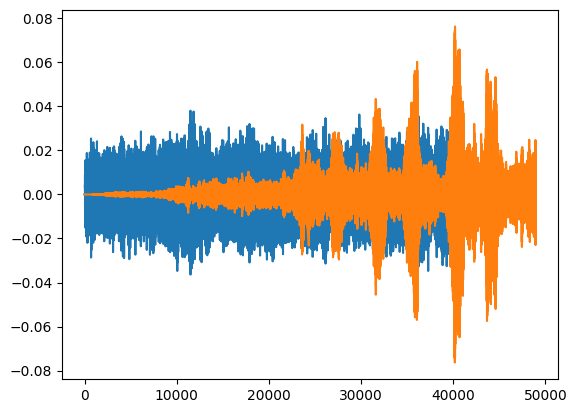

In [ ]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

plt.plot(wave)
plt.plot(nwave)
plt.show()

In [ ]:
# POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
POS = "/content/drive/MyDrive/Bird_project_dataset/Parsed_Capuchinbird_Clips"
# NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')
NEG = "/content/drive/MyDrive/Bird_project_dataset/Parsed_Not_Capuchinbird_Clips"

pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

pos.as_numpy_iterator().next()

positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

lengths = []
# for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
for file in os.listdir(POS):
    tensor_wave = load_wav_16k_mono(os.path.join(POS, file))
    lengths.append(len(tensor_wave))

tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [ ]:
def preproccess(file_path, label):

    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectogram = tf.abs(spectogram)
    spectogram = tf.expand_dims(spectogram, axis = 2)
    return spectogram, label

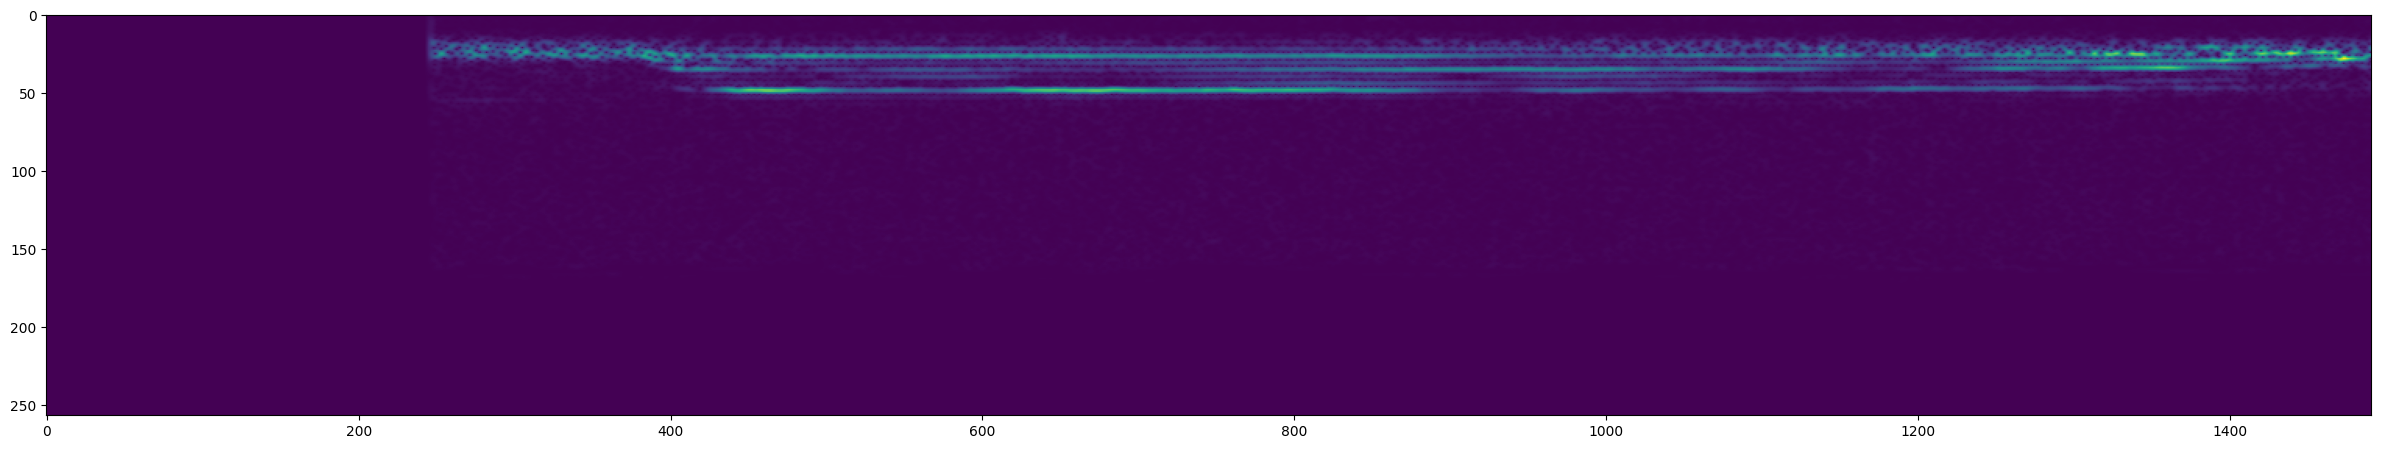

In [ ]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectogram, label = preproccess(filepath, label)

plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

In [ ]:
data = data.map(preproccess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

train = data.take(36)
test = data.skip(36).take(15)

samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [ ]:
model = Sequential()
model.add(Conv2D(16,(3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(Conv2D(8,(3,3), activation='relu'))
model.add(Conv2D(4,(3,3), activation='relu'))
# model.add(Conv2D(16,(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 8)      1160      
                                                                 
 conv2d_2 (Conv2D)           (None, 1485, 251, 4)      292       
                                                                 
 flatten (Flatten)           (None, 1490940)           0         
                                                                 
 dense (Dense)               (None, 128)               190840448 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 190,842,189
Trainable params: 190,842,189


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# a = tf.constant([1, 2, 3])
# print(a.device)
# print(tf.DeviceSpec)

Num GPUs Available:  1


In [ ]:
hist = model.fit(train, epochs=10, validation_data = test)

Epoch 1/10
36/36 [==============================] - 24s 206ms/step - loss: 1.8190 - recall: 0.8917 - precision: 0.7821 - val_loss: 0.1410 - val_recall: 0.9310 - val_precision: 0.9643
Epoch 2/10
36/36 [==============================] - 7s 194ms/step - loss: 0.0555 - recall: 0.9803 - precision: 0.9933 - val_loss: 0.0733 - val_recall: 1.0000 - val_precision: 0.9710
Epoch 3/10
36/36 [==============================] - 7s 185ms/step - loss: 0.0573 - recall: 1.0000 - precision: 0.9871 - val_loss: 0.0795 - val_recall: 1.0000 - val_precision: 0.9846
Epoch 4/10
36/36 [==============================] - 7s 183ms/step - loss: 0.0419 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0480 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 5/10
36/36 [==============================] - 7s 198ms/step - loss: 0.0501 - recall: 1.0000 - precision: 0.9935 - val_loss: 0.0305 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 6/10
36/36 [==============================] - 7s 187ms/step - loss: 0.0306 - recall

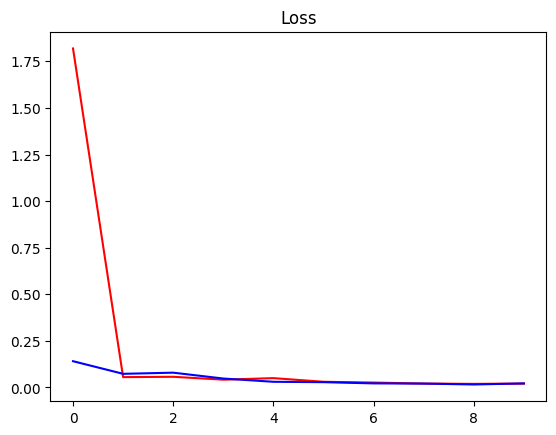

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [ ]:
print(hist.history)

{'loss': [3.137374369543977e-05, 3.01263717119582e-05, 2.0559891709126532e-05, 1.9787268684012815e-05, 1.2777423762599938e-05, 1.0977797501254827e-05], 'recall': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'precision': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_loss': [5.718835745938122e-05, 1.3290641618368682e-05, 1.7790551282814704e-05, 6.926817604835378e-06, 3.0454260922851972e-05, 1.6081585272331722e-05], 'val_recall': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_precision': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


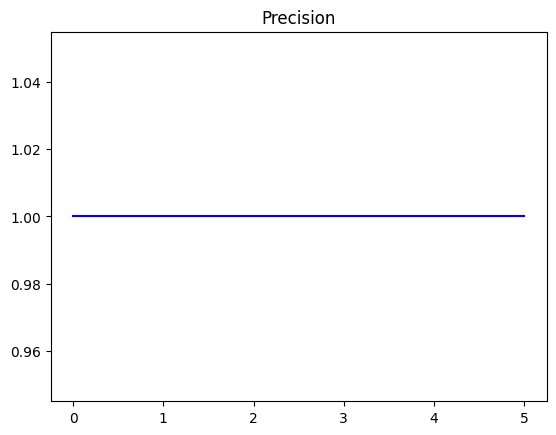

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

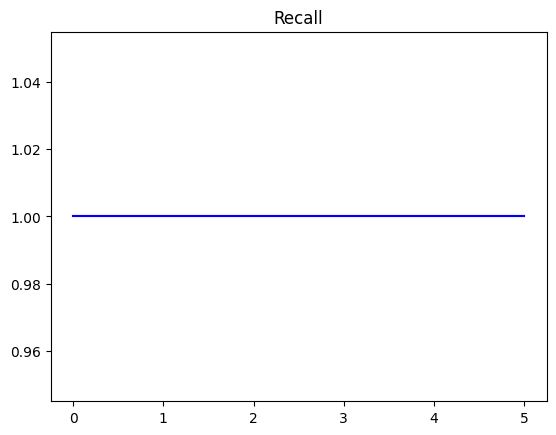

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)


1/1 [==============================] - 0s 58ms/step


In [ ]:
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]


In [ ]:
def load_mp3_16k_mono(filename):
    """ Ucitava MP3 fajl, konvertuje u float tensor, resample na 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Konvertuje tensor i spaja kanale
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample na 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = "/content/drive/MyDrive/Bird_project_dataset/Forest Recordings/recording_00.mp3"

In [ ]:
wav = load_mp3_16k_mono(mp3)


In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)


In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()


In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

1/1 [==============================] - 1s 1s/step


In [ ]:
len(yhat)

60

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]

In [ ]:
calls = tf.math.reduce_sum(yhat).numpy()


In [ ]:
calls

5

In [ ]:
results = {}
for file in os.listdir(os.path.join('drive', 'MyDrive', 'Bird_project_dataset', 'Forest Recordings')):
    FILEPATH = os.path.join('drive', 'MyDrive', 'Bird_project_dataset', 'Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

1/1 [==============================] - 2s 2s/step


In [ ]:
results

{'recording_00.mp3': array([[1.3702108e-06],
        [2.0731800e-08],
        [8.6182445e-07],
        [1.8949639e-03],
        [1.0000000e+00],
        [3.2916966e-10],
        [1.5542652e-07],
        [6.7459854e-10],
        [3.8440220e-08],
        [1.0399439e-05],
        [1.7441390e-06],
        [1.6309762e-06],
        [9.7302654e-07],
        [9.9964070e-01],
        [1.0000000e+00],
        [7.3650632e-08],
        [3.6478101e-14],
        [3.2454420e-08],
        [5.8928649e-06],
        [2.9448506e-07],
        [3.6299880e-06],
        [7.3322376e-08],
        [6.1651172e-06],
        [1.2820601e-05],
        [1.0000000e+00],
        [1.0134512e-10],
        [6.4286476e-10],
        [4.7608328e-08],
        [1.0790535e-07],
        [4.6483486e-08],
        [9.3692648e-07],
        [1.7336670e-05],
        [4.3348822e-10],
        [1.4810704e-15],
        [1.9220820e-07],
        [7.9213727e-08],
        [1.0000000e+00],
        [2.5251357e-14],
        [8.2053276e-08],
     

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_05.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_05.mp3': 0,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_04.mp3': 4,
 'recording_03.mp3': 0,
 'recording_14.mp3': 0,
 'recording_11.mp3': 3,
 'recording_20.mp3': 0,
 'recording_15.mp3': 2,
 'recording_17.mp3': 3,
 'recording_19.mp3': 2,
 'recording_18.mp3': 8,
 'recording_13.mp3': 0,
 'recording_10.mp3': 5,
 'recording_16.mp3': 5,
 'recording_08.mp3': 24,
 'recording_09.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_12.mp3': 0,
 'recording_24.mp3': 0,
 'recording_28.mp3': 4,
 'recording_26.mp3': 2,
 'recording_22.mp3': 2,
 'recording_21.mp3': 1,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_30.mp3': 1,
 'recording_25.mp3': 1,
 'recording_27.mp3': 0,
 'recording_23.mp3': 5,
 'recording_33.mp3': 0,
 'recording_29.mp3': 0,
 'recording_42.mp3': 0,
 'recording_41.mp3': 0,
 'recording_35.mp3': 0,
 'recording_37.mp3': 3,
 'recording_40.mp3': 1,
 'recording_36.mp3': 0,
 'recording_44.mp3': 1,
 'recording_38.

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])